In [2]:
import numpy as np
import pandas as pd
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
import warnings
from sklearn import model_selection
import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings('ignore')

In [33]:
def read_data(file):
    return pd.read_csv(f'../input/raw/{file}')

def save_data(train_df, test_df):

    train_df.to_csv('../input/raw/train.csv')
    print('Train file saved.')
    test_df.to_csv('../input/raw/test.csv')
    print('Test file saved')
    
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df

train = read_data('DowJonesTrain.csv')
test = read_data('DowJonesTest.csv')

In [34]:
def clean_data(data):
    data = data.rename(columns={'Vol.' : 'Vol', 'Change %': 'Change'})
    data.dropna(inplace=True)
    data['Vol'].replace('', np.nan, inplace=True)
    data['Vol'] = data['Vol'].apply(lambda x: x[:-1]) # remove the M at the back
    data['Change'] = data['Change'].apply(lambda x: x[:-1]) # remove the M at the back
    for i in ['Price', 'Open', 'High', 'Low', 'Change', 'Vol']:
        data[i] = data[i].apply(lambda x: float(x.replace(',','')))
    data['prev_change'] = data['Change'].shift(periods=1)
    data.dropna(inplace=True)
    data['Date'] = pd.to_datetime(data['Date'])
    data['day'] = data['Date'].dt.day.astype("int8")
    data['month'] = data['Date'].dt.month.astype("int8")
    data['year'] = data['Date'].dt.year.astype("int16")
    data['weekday'] = data['Date'].dt.weekday.astype("int8")
    data['quarter'] = data['Date'].dt.quarter.astype("int8")
    data = reduce_mem_usage(data)
    return data

In [35]:
train = clean_data(train)
test = clean_data(test)
test.head()

Memory usage after optimization is: 0.05 MB
Decreased by 53.8%
Memory usage after optimization is: 0.04 MB
Decreased by 53.8%


,Date,Price,Open,High,Low,Vol,Change,prev_change,day,month,year,weekday,quarter
1,2020-09-24,26816.0,26720.0,27088.0,26544.0,448.75,0.199951,1.339844,24,9,2020,3,3
2,2020-09-23,26768.0,27408.0,27472.0,26720.0,463.25,-1.919922,0.199951,23,9,2020,2,3
3,2020-09-22,27296.0,27168.0,27328.0,26992.0,423.25,0.520020,-1.919922,22,9,2020,1,3
4,2020-09-21,27152.0,27488.0,27488.0,26720.0,523.50,-1.839844,0.520020,21,9,2020,0,3
5,2020-09-18,27664.0,27872.0,27952.0,27488.0,704.00,-0.879883,-1.839844,18,9,2020,4,3


In [36]:
save_data(train, test)

Train file saved.
Test file saved


In [37]:
train.head()

,Date,Price,Open,High,Low,Vol,Change,prev_change,day,month,year,weekday,quarter
1,2015-12-30,17600.0,17712.0,17712.0,17584.0,59.75000,-0.660156,-1.019531,30,12,2015,2,4
2,2015-12-29,17728.0,17552.0,17744.0,17552.0,69.87500,1.099609,-0.660156,29,12,2015,1,4
3,2015-12-28,17536.0,17536.0,17536.0,17440.0,59.78125,-0.140015,1.099609,28,12,2015,0,4
4,2015-12-24,17552.0,17600.0,17600.0,17536.0,40.34375,-0.290039,-0.140015,24,12,2015,3,4
5,2015-12-23,17600.0,17424.0,17600.0,17424.0,92.81250,1.059570,-0.290039,23,12,2015,2,4


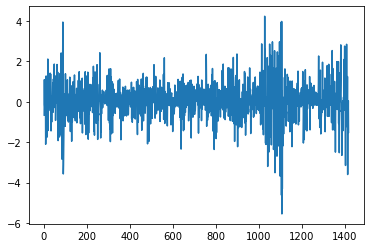

In [38]:
train['Change'].plot()

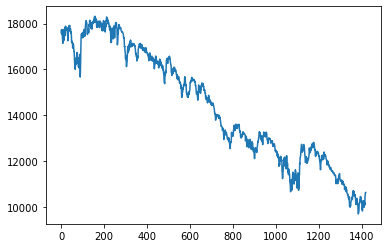

In [39]:
train['Price'].plot()

In [154]:
from statsmodels.tsa.arima_model import ARIMA

In [157]:
model = ARIMA(np.asarray(train['prev_change']), order=(5,1,0))

In [159]:
model.fit()
preds = model.predict(test['prev_change'])
preds

array([1.33984375, 1.07975365, 2.2197206 , ...,        nan,        nan,
              nan])

In [40]:
train = pd.read_csv('../input/raw/train.csv')
train.head()

,Unnamed: 0,Date,Price,Open,High,Low,Vol,Change,prev_change,day,month,year,weekday,quarter
0,1,2015-12-30,17600.0,17710.0,17710.0,17580.0,59.75,-0.66,-1.02,30,12,2015,2,4
1,2,2015-12-29,17730.0,17550.0,17740.0,17550.0,69.90,1.10,-0.66,29,12,2015,1,4
2,3,2015-12-28,17540.0,17540.0,17540.0,17440.0,59.78,-0.14,1.10,28,12,2015,0,4
3,4,2015-12-24,17550.0,17600.0,17600.0,17540.0,40.34,-0.29,-0.14,24,12,2015,3,4
4,5,2015-12-23,17600.0,17420.0,17600.0,17420.0,92.80,1.06,-0.29,23,12,2015,2,4


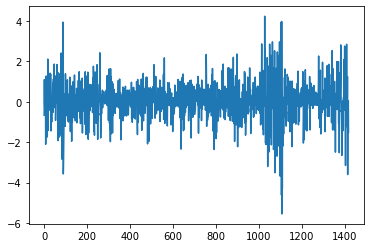

In [41]:
train.Change.plot()

In [42]:
train.Change.describe()

count    1417.000000
mean        0.038885
std         0.923408
min        -5.550000
25%        -0.390000
50%         0.050000
75%         0.510000
max         4.240000
Name: Change, dtype: float64

In [52]:
train['change_class'] = (train.Change >= 1.0).astype('int')
train.head()

,Unnamed: 0,Date,Price,Open,High,Low,Vol,Change,prev_change,day,month,year,weekday,quarter,change_class
0,1,2015-12-30,17600.0,17710.0,17710.0,17580.0,59.75,-0.66,-1.02,30,12,2015,2,4,0
1,2,2015-12-29,17730.0,17550.0,17740.0,17550.0,69.90,1.10,-0.66,29,12,2015,1,4,1
2,3,2015-12-28,17540.0,17540.0,17540.0,17440.0,59.78,-0.14,1.10,28,12,2015,0,4,0
3,4,2015-12-24,17550.0,17600.0,17600.0,17540.0,40.34,-0.29,-0.14,24,12,2015,3,4,0
4,5,2015-12-23,17600.0,17420.0,17600.0,17420.0,92.80,1.06,-0.29,23,12,2015,2,4,1


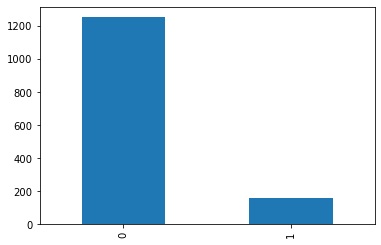

In [53]:
train.change_class.value_counts().plot(kind='bar')

In [54]:
train.change_class.value_counts()

0    1254
1     163
Name: change_class, dtype: int64

In [56]:
save_data(train, test)

Train file saved.
Test file saved


In [57]:
read_data('train.csv').head()

,Unnamed: 0,Unnamed: 0.1,Date,Price,Open,High,Low,Vol,Change,prev_change,day,month,year,weekday,quarter,change_class
0,0,1,2015-12-30,17600.0,17710.0,17710.0,17580.0,59.75,-0.66,-1.02,30,12,2015,2,4,0
1,1,2,2015-12-29,17730.0,17550.0,17740.0,17550.0,69.90,1.10,-0.66,29,12,2015,1,4,1
2,2,3,2015-12-28,17540.0,17540.0,17540.0,17440.0,59.78,-0.14,1.10,28,12,2015,0,4,0
3,3,4,2015-12-24,17550.0,17600.0,17600.0,17540.0,40.34,-0.29,-0.14,24,12,2015,3,4,0
4,4,5,2015-12-23,17600.0,17420.0,17600.0,17420.0,92.80,1.06,-0.29,23,12,2015,2,4,1


In [58]:
read_data('test.csv').head()

,Unnamed: 0,Date,Price,Open,High,Low,Vol,Change,prev_change,day,month,year,weekday,quarter
0,1,2020-09-24,26820.0,26720.0,27090.0,26540.0,448.8,0.20,1.34,24,9,2020,3,3
1,2,2020-09-23,26770.0,27410.0,27470.0,26720.0,463.2,-1.92,0.20,23,9,2020,2,3
2,3,2020-09-22,27300.0,27170.0,27330.0,26990.0,423.2,0.52,-1.92,22,9,2020,1,3
3,4,2020-09-21,27150.0,27490.0,27490.0,26720.0,523.5,-1.84,0.52,21,9,2020,0,3
4,5,2020-09-18,27660.0,27870.0,27950.0,27490.0,704.0,-0.88,-1.84,18,9,2020,4,3
